In [1]:
from data_utils import BYOLTransform, NoTransform

In [2]:
a = BYOLTransform(((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))

In [3]:
from torchvision.datasets import CIFAR10

In [4]:
t = CIFAR10("./data/CIFAR10/", False, a)

In [5]:
a, b=next(iter(t))

In [6]:
len(a)

3

In [7]:
from modules import EMAHelper, AverageMeter
from modules import BYOL_loss, Classifier_loss
from modules import ResNetModel, LinearClassifier

In [8]:
from args import args_parser
args = args_parser()

In [9]:
import torch
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

online_network = ResNetModel(args, "online").to(DEVICE) 
target_network = ResNetModel(args, "target").to(DEVICE)

c:\Users\David\AppData\Local\pypoetry\Cache\virtualenvs\byol-pytorch-BuxpsX5h-py3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\David\AppData\Local\pypoetry\Cache\virtualenvs\byol-pytorch-BuxpsX5h-py3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
target_network =target_network.eval()

In [11]:
from data_utils import DataManager

In [12]:
data_manager = DataManager(args)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
train_loader = data_manager.get_loader("train")

In [14]:
images, labels = next(iter(test_loader))

In [15]:
images = images.to(DEVICE)

In [16]:
test_embeddings = target_network(images, return_embedding=True)

In [17]:
test_embeddings = test_embeddings.detach().cpu()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1024 samples in 0.001s...
[t-SNE] Computed neighbors for 1024 samples in 0.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 5.527397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.574829
[t-SNE] KL divergence after 1000 iterations: 1.487476


C:\Users\David\AppData\Local\Temp\ipykernel_30168\2021490713.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


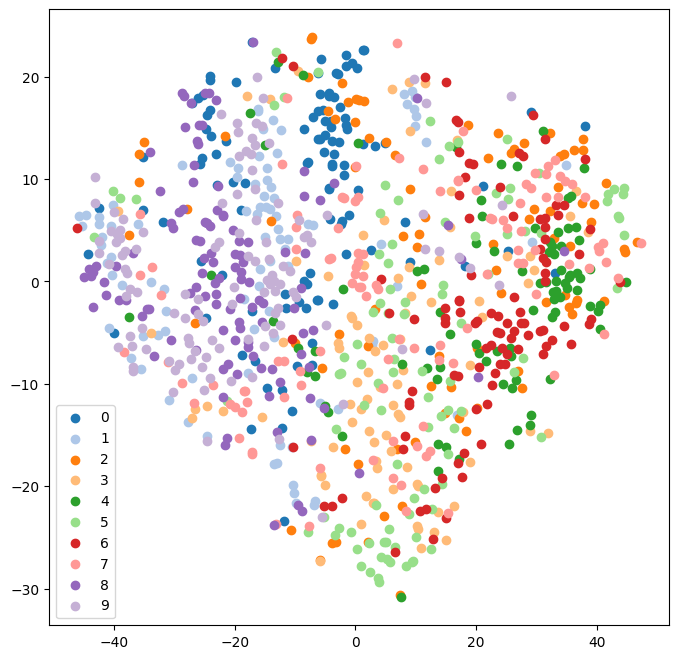

In [18]:
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1, random_state=0)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
figure = plt.figure(1, figsize=(8, 8))
num_categories = 10
for lab in range(num_categories):
    indices = labels == lab
    plt.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab, alpha=1)
plt.legend(markerscale=1)
plt.savefig("test.png", dpi=800)

In [20]:
args.pretrained

True

In [22]:
data_manager.test_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

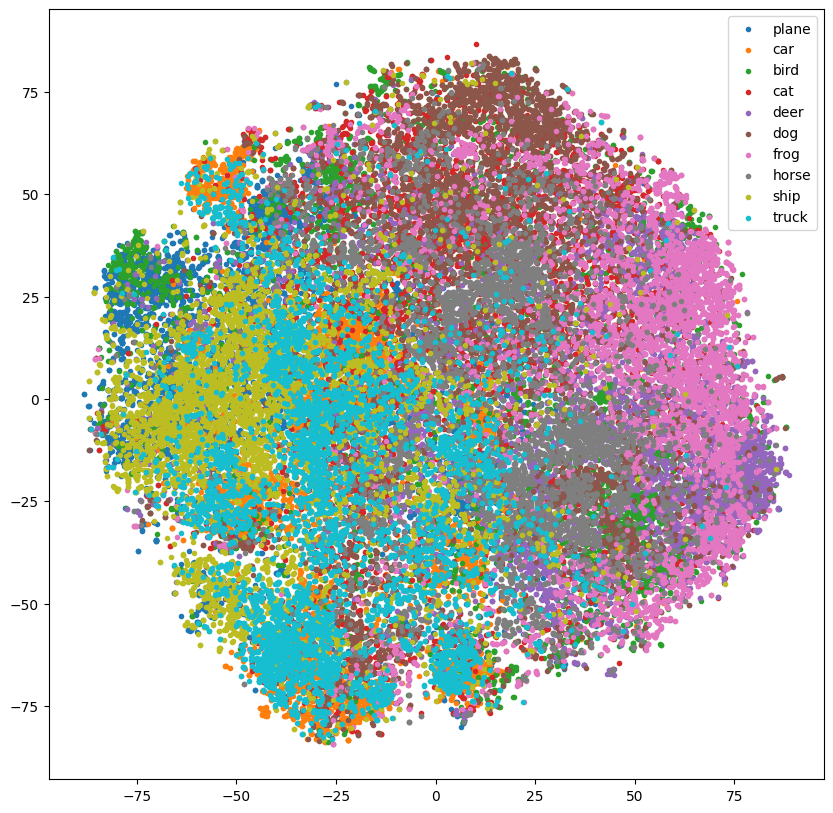

In [26]:
actual = []
deep_features = []

with torch.no_grad():
    for data in train_loader:
        images, labels = data[0][0].to(DEVICE, non_blocking=True), data[1].to(DEVICE, non_blocking=True)
        features = target_network(images, return_embedding=True) # 512 차원

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

tsne = TSNE(n_components=2, random_state=0) # 사실 easy 함 sklearn 사용하니..
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(10, 10))

cifar = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha=1)

plt.legend()
plt.show()

In [60]:
from torchvision.models import resnet18, resnet50
from torch import nn

In [70]:
temp = resnet18(pretrained=True)
temp.fc = nn.Identity()

c:\Users\David\AppData\Local\pypoetry\Cache\virtualenvs\byol-pytorch-BuxpsX5h-py3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\David\AppData\Local\pypoetry\Cache\virtualenvs\byol-pytorch-BuxpsX5h-py3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [67]:
temp = temp.cuda()

In [68]:
temp(images).size()

torch.Size([128, 2048])

In [80]:
a=torch.empty((0, 512))

In [71]:
temp = temp.cuda()

In [72]:
out = temp(images)

In [74]:
out = out.detach().cpu()

In [83]:
a = torch.cat([a, out])


In [84]:
a.size()

torch.Size([256, 512])

In [86]:
labels.size()

torch.Size([128])

In [90]:
a=torch.empty((0))

In [92]:
a = torch.cat((a, labels))

In [93]:
a.size()

torch.Size([256])

In [1]:
%matplotlib notebook


In [3]:
import glob
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.PNG")]
    frame_one = frames[0]
    frame_one.save("my_awesome.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
    
    

In [5]:
make_gif("./tsne")